# This notebook uses star gene counts

In [1]:
library(repr)
options(repr.plot.width=5, repr.plot.height=5)

In [4]:
library(dplyr)
library(tidyverse)
library(WriteXLS)

In [5]:
library(DESeq2)
library(apeglm)
library(EnhancedVolcano)
library(ggplot2)

In [377]:
library(pheatmap)

In [6]:
setwd('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/20190816/star/counts')

In [7]:
dir(pattern='*.csv')

[1] "conditions_group1.csv"              "DEgenes_output1.csv"               
[3] "HighlyExpressedGenes.csv"           "RNAseq_allgene_cnts.csv"           
[5] "rnaseq_flen.csv"                    "RNAseq_tdNeg_120GeneSet_counts.csv"
[7] "TFsc_rnaseq_cnts.csv"

In [8]:
cnts = read.csv(file = 'TFsc_rnaseq_cnts.csv', row.names = 1)

In [9]:
class(cnts)
head(cnts, 2)

[1] "data.frame"

,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,⋯,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [10]:
mean_cnts <- apply(cnts[,1:22], 1, mean)
var_cnts <- apply(cnts[,1:22], 1, var)
df <- data.frame(mean_cnts, var_cnts)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 26202 rows containing non-finite values (stat_smooth).”

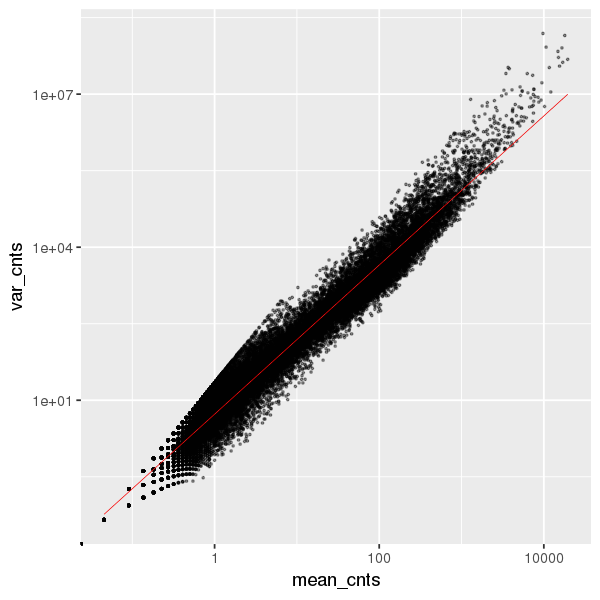

In [11]:
ggplot(df) + geom_point(aes(x=mean_cnts, y=var_cnts), size=.4, alpha=0.4) + 
             geom_smooth(aes(x=mean_cnts, y=var_cnts),method = 'glm', size=.2, color='red') +
             scale_y_log10() + scale_x_log10()

# ACT I

**WT with devlopment:**

Condition |Sample
:--------:|:-------:
ES w RI  |  1, 2
ES w/o RI |   13, 14
+DOX 15h   | 15, 16
+DOX Day1   | 17, 18
+DOX Day2   | 19, 20
+DOX Day4   | 7, 8
+DOX Day7   | 21, 22

In [423]:
cols1 <- c('S01', 'S02','S13','S14','S15','S16','S17','S18','S19','S20','S07','S08','S21','S22') # relevent samples
cnts1 <- cnts[,cols1]

In [424]:
colnames(cnts1)
head(cnts1,2)

[1] "S01" "S02" "S13" "S14" "S15" "S16" "S17" "S18" "S19" "S20" "S07" "S08"
[13] "S21" "S22"

,S01,S02,S13,S14,S15,S16,S17,S18,S19,S20,S07,S08,S21,S22
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
gtf_lookup = read.csv('/gpfs/commons/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.gene_idTOgene_name.txt')

In [15]:
gene_ids1 = rownames_to_column(cnts1, 'gene_id')[,1:2]

In [16]:
gtf_lookup$gene_id <- as.character(gtf_lookup$gene_id)
gene_names1 = left_join(gene_ids1, gtf_lookup, 'gene_id')[,c(3)] %>% as.character

In [422]:
coldata1 <- read.csv('conditions_group1.csv')

In [420]:
coldata1

condition,group
ES_wo_RI,ES
ES_wo_RI,ES
ES_w_RI,ES
ES_w_RI,ES
DOX_15H,DOX
DOX_15H,DOX
DOX_1D,DOX
DOX_1D,DOX
DOX_2D,DOX
DOX_2D,DOX


In [425]:
dds1 <- DESeqDataSetFromMatrix(countData = cnts1, colData = coldata1, design = ~ group) 

In [426]:
all(rownames(dds1) == gene_ids1$gene_id) # make sure all gene_ids are the same as the gene ids in dds

[1] TRUE

In [427]:
mcols(dds1) <- cbind(mcols(dds1), 'gene_name' = gene_names1) # adding gene_names to counts dds

In [428]:
keep1 <- rowSums(counts(dds1)) >= 10 # pre-analysis filter to remove very low read count genes
dds1 <- dds1[keep1,]

In [429]:
dim(dds1)

[1] 22604    14

In [430]:
# specify factor level (instead of letting R to decide)
dds1$condition <- factor(dds1$condition, levels = unique(as.vector(coldata1$condition)))
dds1$group <- factor(dds1$group, levels = unique(as.vector(coldata1$group)))

In [431]:
counts(dds1) %>% head()

,S01,S02,S13,S14,S15,S16,S17,S18,S19,S20,S07,S08,S21,S22
ENSG00000233750.3,0,0,0,0,0,0,0,0,0,0,0,0,15,0
ENSG00000268903.1,3,1,0,0,0,4,0,0,0,0,0,7,0,0
ENSG00000225972.1,7,1,7,35,0,18,3,1,4,1,1,5,2,6
ENSG00000225630.1,45,41,264,5,78,114,2,211,51,3,3,30,11,34
ENSG00000229344.1,3,0,2,1,2,3,1,8,1,5,0,2,3,0
ENSG00000240409.1,0,0,0,2,0,1,10,0,0,0,0,0,0,0


In [432]:
dds1 <- DESeq(dds1)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1900 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [433]:
resultsNames(dds1)

[1] "Intercept"       "group_DOX_vs_ES"

In [434]:
res1 <- results(dds1) # modelling ES vs. +DOX

In [437]:
# add gene_name to result
if (all(rownames(res1) == rownames(dds1))) {
    res1.df <- cbind(res1, 'gene_name' = mcols(dds1)$gene_name)    
}  else {
    print("Rownames don't match!")
}

In [438]:
res1 %>% head

log2 fold change (MLE): group DOX vs ES 
Wald test p-value: group DOX vs ES 
DataFrame with 6 rows and 6 columns
                           baseMean     log2FoldChange            lfcSE
                          <numeric>          <numeric>        <numeric>
ENSG00000233750.3                 0                  0                0
ENSG00000268903.1 0.845750875619962  0.028017975756252 3.29941366014872
ENSG00000225972.1  6.31483095246436  -1.62551258415038 1.09737790991284
ENSG00000225630.1  57.2166611137355 -0.405250350557316 1.01745788591981
ENSG00000229344.1  2.15545011509387  0.959571124294253 1.33080823843808
ENSG00000240409.1 0.963719678513681   1.20303287701445 3.35901520233594
                                 stat            pvalue              padj
                            <numeric>         <numeric>         <numeric>
ENSG00000233750.3                   0                 1                NA
ENSG00000268903.1 0.00849180449685995 0.993224601728532                NA
ENSG00000225972

#### Log fold change shrinkage LFC for visulaization and ranking (for easier/cleaner visulization)

In [134]:
resultsNames(dds1)

[1] "Intercept"       "group_DOX_vs_ES"

In [101]:
resLFC1 <- lfcShrink(dds1, coef='group_DOX_vs_ES', type='apeglm')

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


In [102]:
resLFC1

log2 fold change (MAP): group DOX vs ES 
Wald test p-value: group DOX vs ES 
DataFrame with 22604 rows and 5 columns
                           baseMean        log2FoldChange               lfcSE
                          <numeric>             <numeric>           <numeric>
ENSG00000233750.3                 0  2.11057456762802e-07 0.00144269503776336
ENSG00000268903.1 0.845750875619962  2.32870688964804e-09 0.00144269490161574
ENSG00000225972.1  6.31483095246436 -1.59268029762379e-06  0.0014426939869442
ENSG00000225630.1  57.2166611137355  -4.2231596742759e-07 0.00144269346086149
ENSG00000229344.1  2.15545011509387  1.19238300662716e-07 0.00144269434561159
...                             ...                   ...                 ...
ENSG00000210196.2  59.9475205332762  1.62927481544906e-06 0.00144269170013741
ENSG00000276256.1  15.0724744233232  8.75964014520544e-07 0.00144269469145734
ENSG00000271254.6                 0  1.99658223928034e-07 0.00144269503719417
ENSG00000278673.1 0.66323

### MA-plot

In [135]:
plotMA(res1, ylim=c(-10,10))
#idx <- identify(res1$baseMean, res$log2FoldChange)
#rownames(res)[idx]

ERROR: Error in plotMA(res1, ylim = c(-10, 10)): Error from the generic function 'plotMA' defined in package 'BiocGenerics': no S4 method definition for argument 'res1' of class 'DataFrame' was found. Did you perhaps mean calling the function 'plotMA' from another package, e.g. 'limma'? In that case, please use the syntax 'limma::plotMA'.


In [121]:
#### number of DE hit genes (DOX vs. ES)at given FDR

In [439]:
fdr = 0.1

In [440]:
sum(res1$padj < fdr, na.rm=T)

[1] 1978

In [441]:
sigID1 <- res1[!is.na(res1$padj) & res1$padj < fdr,] %>% as.data.frame %>% rownames_to_column('gene_id')

In [442]:
sigID1 %>% head

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000223764.2,20.40996,7.486539,1.6958498,4.414624,1.011857e-05,0.0004038397
ENSG00000187961.14,17.12620,2.980006,1.1823361,2.520439,1.172085e-02,0.0930690623
ENSG00000188290.10,34.56093,3.262860,0.7273971,4.485666,7.268650e-06,0.0003087349
ENSG00000187608.10,14.66726,-3.566445,1.1066517,-3.222735,1.269730e-03,0.0194240571
ENSG00000131591.17,17.51026,2.949941,0.7764793,3.799124,1.452086e-04,0.0035786732
ENSG00000176022.7,98.98255,1.103594,0.3491472,3.160827,1.573219e-03,0.0227558867


In [443]:
sigGenes1 <- counts(dds1, normalized=T) %>% as.data.frame %>% 
                add_column(.before=1,'gene'=mcols(dds1)$gene_name) %>% rownames_to_column('gene_id')# add gene_name
sigGenes1 <- left_join(sigID1[,c('gene_id','padj')], sigGenes1, by = 'gene_id') %>% select(-c('gene_id')) %>%
                arrange(padj)

In [444]:
sigGenes1 %>% head(10)
sigGenes1 %>% dim

padj,gene,S01,S02,S13,S14,S15,S16,S17,S18,S19,S20,S07,S08,S21,S22
1.127215e-97,INSM1,3.3764893,1.675652,9.8295509,4.220807,2020.4365,1573.5464,1662.1163,1949.4850,2134.0972,2267.2023,1340.2035,1364.5131,1917.4913,1750.7251
6.932293e-42,HES6,93.6975786,134.052189,232.1286261,149.838651,5244.7600,4782.8597,10010.4255,6525.0659,6863.0431,8293.1636,4045.5177,4110.2136,3700.2947,2925.2004
2.627878e-41,DLL3,16.0383243,55.296528,14.3662668,8.441614,2834.3688,2946.9053,6947.1431,6577.9261,5550.5475,8237.9542,3159.3932,2949.2658,1968.1802,1733.6330
8.927372e-31,GFRA1,1.6882447,9.216088,0.0000000,0.000000,570.5378,470.7113,391.9492,602.6065,847.4381,758.4493,1393.8499,1522.2241,1381.6364,1495.5637
1.483785e-30,CHRNA3,3.3764893,2.513479,0.7561193,9.496816,406.5300,275.0325,624.6036,484.1996,1632.0074,2011.9723,1682.1996,1609.0694,590.8885,1251.3900
1.794579e-23,ZEB2,0.8441223,0.000000,3.7805965,0.000000,215.4783,110.9147,425.4850,202.9833,428.8864,532.1816,367.8614,331.4016,237.5140,363.8188
8.149815e-23,NEFM,5.0647340,1.675652,65.7823794,11.607219,1978.5622,1906.2906,7589.5625,8589.7862,2093.6200,3415.7371,5296.6297,4266.5351,19625.3202,24064.5349
3.342908e-21,CAMK2N1,13.5059573,9.216088,16.6346247,28.490448,225.9469,323.7267,244.1823,439.7971,446.1107,577.4352,767.3359,808.7033,1233.9143,1091.4563
3.342908e-21,PHOX2B,0.0000000,0.000000,0.7561193,1.055202,700.5227,497.7637,1132.8800,693.5261,1552.7754,1148.5348,1141.9032,937.2343,418.5461,496.8934
7.248395e-21,EBF2,0.8441223,0.000000,1.5122386,1.055202,480.6824,292.1656,571.1560,382.7080,294.5364,340.3066,227.9974,191.0596,120.2053,191.6763


[1] 1978   16

In [445]:
#### 1000 Most significant (DOX vs. ES) ranked by padj
top_n(sigGenes1, n = -1000, wt = padj)[,1:16] %>% column_to_rownames('gene') %>% as.matrix %>% tail

,padj,S01,S02,S13,S14,S15,S16,S17,S18,S19,S20,S07,S08,S21,S22
VTI1A,0.01949554,45.5826058,50.26957,64.2701408,26.380044,74.152462,87.469343,165.58283,89.862379,49.9506214,112.228777,113.040749,120.888635,111.51573,101.33207
HPCA,0.01974823,0.0000000,0.00000,0.0000000,0.000000,0.000000,15.329679,0.00000,0.000000,8.6121761,0.000000,10.537697,33.348589,21.72384,36.62605
AL117329.1,0.02002180,0.8441223,0.00000,0.0000000,1.055202,9.596201,9.017458,10.47993,4.228818,0.8612176,1.810142,2.873917,1.389525,63.72327,10.98781
SIAH3,0.02002989,0.0000000,0.00000,0.7561193,0.000000,0.000000,0.000000,20.95985,0.000000,29.2813988,0.000000,36.402953,21.537630,43.44769,12.20868
ZMYND8,0.02011651,903.2108925,594.01876,759.1437806,606.741015,357.676580,357.993083,504.08445,555.032341,228.2226668,378.319586,199.258270,228.576786,419.99431,336.95965
LONP2,0.02020506,75.1268873,74.56653,33.2692493,49.594483,127.367758,107.307750,116.32718,64.489472,162.7701284,63.354955,174.350986,223.713451,275.16868,286.90405


In [446]:
# most abundant genes
most_abundant.mt1 <- top_n(sigGenes1, n = 1500, wt = rowSums(sigGenes1[,3:16]))[,2:16] %>% column_to_rownames('gene') %>% as.matrix

In [449]:
write.table(most_abundant.mt1, 'most_abundent_genes_DOXvsES.csv', quote=F, sep=',', row.names = F)

In [447]:
ano1 <- as.data.frame(colData(dds1)[,c('condition','group')])

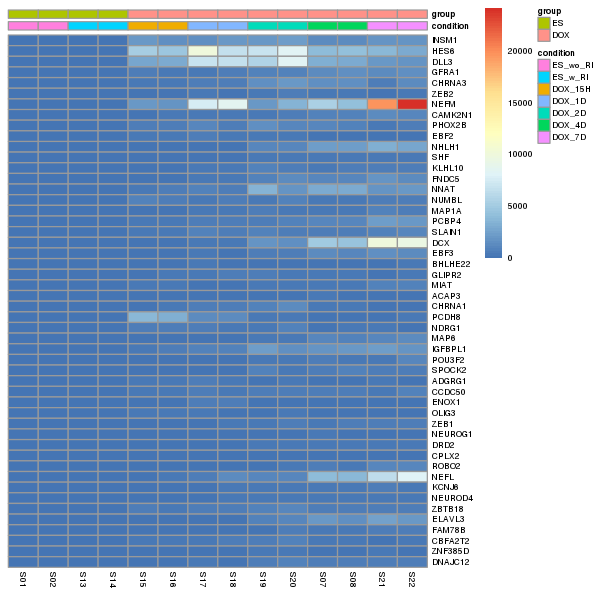

In [448]:
pheatmap(most_abundant.mt1[1:50,], cluster_rows=F, show_rownames=T, cluster_cols = F, annotation = ano1,
         fontsize=5, title = 'Top 50 of most abundant genes (FDR 0.1, DOX vs ES)')

In [450]:
pheatmap(most_abundant.mt1[1:1000,], cluster_rows=F, show_rownames=T, cluster_cols = F, annotation = ano1,
         fontsize=5, title = 'Top 1000 of most abundant genes (FDR 0.1, DOX vs ES)', filename='1000MostAbundantGenes_Dox2ES.heatmap.pdf',
        width = 8, height = 66, silent = T)

In [466]:
#### 1000 Most significant (DOX vs. ES) ranked by padj
most_sig.mt1 <- top_n(sigGenes1, n = -1000, wt = padj)[,1:16] %>% column_to_rownames('gene') %>% as.matrix

In [469]:
write.table(most_sig.mt1, 'most_abundent_genes_DOXvsES.csv', quote=F, sep=',', row.names = F)

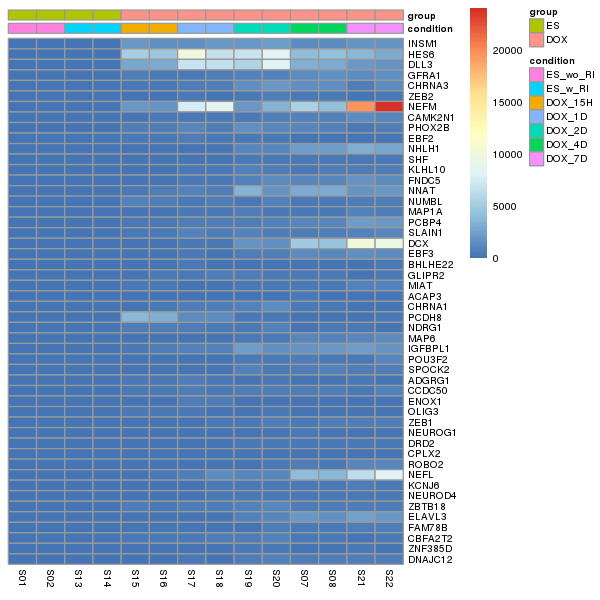

In [468]:
pheatmap(most_sig.mt1[1:50,c(2:15)], cluster_rows=F, show_rownames=T, cluster_cols = F, annotation = ano1,
         fontsize=6, title = 'Top 50 of most significant genes (FDR 0.1, DOX vs ES)')

In [471]:
pheatmap(most_sig.mt1[,2:15], cluster_rows=F, show_rownames=T, cluster_cols = F, annotation = ano1,
         fontsize=4, title = 'Top 1000 of most significant genes (FDR 0.1, DOX vs ES)', filename='1000MostSignificantGenes_Dox2ES.heatmap.pdf',
        width = 8, height = 66, silent = T)

# ACT II
**WT compared to ZBTB18KO**

Condition  |  Sample    
:---------:|:-------:
WT.ES  |  1, 2    
108.ES |   3, 4    
112.ES |   5, 6    
WT.Day4  |  7,8    
108.Day4 |   9, 10    
112.Day4 |   11, 12